In [55]:
#-----Loading packages--------------
import pyfftw
import numpy as np
import scipy.fftpack as fftpack
from scipy.special import laguerre
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py

### 1. Harmonic  Potential

In [56]:
mass = 1.
omega = 1.

def Potential(x):
        return 0.5*mass*omega**2*x**2
    
#----Gradient of quartic potencial

def dPotentialdx(x):  
    return mass*omega**2*x

### 2. Parameters in atomic units

In [57]:
X_gridDIM    =  512         # Discretization grid size in X 
X_amplitude  =  18          # Window range -X1_amplitude to X1_amplitude
dt           =  0.001       # Time increment
timeSteps    =  800         # Number of iterations
hbar         =  1           # Plank constant

#-----Discretization resolution-----

dX =  2.*X_amplitude/float(X_gridDIM)
dK =  2.*np.pi/(2.*X_amplitude)
K_amplitude = dK*X_gridDIM/2.


#-----vectors with range of coordinates-----

timeRange     =  np.array(range(0,timeSteps+1))*dt 

X_range      =  np.linspace(-X_amplitude      , X_amplitude  -dX , X_gridDIM )
K_range      =  np.linspace(-K_amplitude      , K_amplitude  -dK , X_gridDIM)
X            =  fftpack.fftshift( X_range )
K            =  fftpack.fftshift( K_range )


print 'dX = ',dX,'            X_amplitude = ', X_amplitude
print 'dK = ',dK,'       K_amplitude = ', K_amplitude
print ""
print 'dK = ',dK,' must be in most cases not too different from dX/dt =', dX/dt
print ""
print 'Time of simulation :', np.max(timeRange) - np.min(timeRange),'(a.u.)'


dX =  0.0703125             X_amplitude =  18
dK =  0.174532925199        K_amplitude =  44.6804288511

dK =  0.174532925199  must be in most cases not too different from dX/dt = 70.3125

Time of simulation : 0.8 (a.u.)


### 3. USEFULL FUNCTIONS

### 3.1 Wigner transform

In [58]:
def W_Transform(Phi):
    
    x     = X[np.newaxis , :] 
    k     = K[np.newaxis , :]

    Theta = X[:, np.newaxis]
    

    PsiPlus   = Phi[np.newaxis,:]  
    PsiMinus  = Phi[np.newaxis,:] 
    
    # Making real matrices

    x = x + 0*Theta
    k = k + 0*Theta

    Theta = Theta + 0*x
    
    PsiPlus  = PsiPlus  + 0*Theta
    PsiMinus = PsiMinus + 0*Theta

    PsiPlus = fftpack.ifft( np.exp(+1j*k*hbar*Theta/2.)*fftpack.fft(PsiPlus , axis=1) , axis=1 )

    PsiMinus = fftpack.ifft( np.exp(-1j*k*hbar*Theta/2.)*fftpack.fft(PsiMinus , axis=1) , axis=1 )

    B = (PsiMinus)*np.conj(PsiPlus)
    
    W=fftpack.ifft(B,axis=0)
    
    # Normalization
    
    W /= np.sum(W)*dX*dK
    
    return W 

### 3.2 Plot Wigner Function

In [59]:
# Matrix of classical Hamiltonian :

Hamiltonian_Classical = fftpack.fftshift( (K[:,np.newaxis])**2/(2*mass) + Potential(X[np.newaxis,:]) )


def PlotWigner(W):
    
    print "max imaginary = ",np.max(np.imag(W))
    
    W = np.real(W)
    
    W = fftpack.fftshift( W )
    
    global_color_max = 0.17          #  Maximum value used to select the color range
    global_color_min = -0.31         # 
        
    print 'min real = ', np.min( W ), ' max real = ', np.max( W )
    
    print 'normalization = ', np.sum( W )*dX*dK
    zero_position =  abs( global_color_min) / (abs( global_color_max) + abs(global_color_min)) 
    wigner_cdict = {'red' 	: 	((0., 0., 0.),
							(zero_position, 1., 1.), 
							(1., 1., 1.)),
					'green' :	((0., 0., 0.),
							(zero_position, 1., 1.),
							(1., 0., 0.)),
					'blue'	:	((0., 1., 1.),
							(zero_position, 1., 1.),
							(1., 0., 0.)) }
    wigner_cmap = matplotlib.colors.LinearSegmentedColormap('wigner_colormap', wigner_cdict, 256)

    fig, ax = plt.subplots(figsize=(12, 5))

    
    x_min = -X_amplitude
    x_max = X_amplitude - dX
    
    p_min = -K_amplitude
    p_max = K_amplitude - dK
    
    cax = ax.imshow( W ,origin='lower',interpolation='none',
                    extent=[ x_min , x_max, p_min, p_max],
                    vmin= global_color_min, vmax=global_color_max, cmap=wigner_cmap)
    
    cbar = fig.colorbar(cax, ticks=[-0.3, -0.2,-0.1, 0, 0.1, 0.2 , 0.3])
    #ax.set_aspect(1/4.)
    
    ax.set_ylim( x_min, x_max)
    
    xlabel("$x  \\ (a.u.) $")
    ylabel("$p  \\ (a.u.)$")
    ax.contour( Hamiltonian_Classical ,
    arange(0, 300, 35 ),origin='lower',extent=[x_min,x_max,p_min,p_max],
    linewidths=0.25,colors='k')
    
    return 

### 3.3 Negative area

In [60]:
def NegArea(W):
    
    return np.sum(W[np.nonzero( W.real < 0. )]).real*dK*dX


### 3.4 Theorical solution of Harmonic oscillator in phase space

In [61]:
def  Wigner_HarmonicOscillator(n,m,Omega,x_init,p_init):
    """
    Wigner function of the Harmonic oscillator
            Parameters
            x,p  : center of wave packet
            n    : Quantum number  
    """
    r2 = m*Omega**2*((X[np.newaxis,:] - x_init))**2 + ((K[:,np.newaxis] - p_init ))**2/m 
    return  (-1)**(n)*laguerre(n)( 2*r2  )*np.exp(-r2 )

### 3.5 Plot Marginals and compare probabilities 

In [62]:
def Plot_Marginals_prob(W , Phi ,main_title):
    """ This functions compare marginals with density probability """
    
    #------Normalization of Phi in x and k spaces:
       
    norm_x =  np.sqrt( np.sum( np.abs(Phi)**2 )*dX )
    Phi_x = Phi / norm_x
    
    print ' The renormalized state norm in x space is :  ', \
    np.sqrt( np.sum( np.abs(Phi_x)**2 )*dX )
    
   
       
    Phi_k = fftpack.fft(Phi)
    Phi_k /= np.sqrt( np.sum( np.abs(Phi_k)**2 )*dK )

    print ' The renormalized state norm in k space is :', \
    np.sqrt( np.sum( np.abs(   Phi_k   )**2 )*dK )
    
    #------ Normalization of W
    
    W  = W.real
    W /= np.sum(W)*dX*dK
    
    #-----  Marginals
    
    W_x = np.sum(W,axis=0)*dK
    W_p = np.sum(W,axis=1)*dX
    
    #------ Plotting
    
    fig, ax = plt.subplots(figsize=(16, 6))      
    
    plt.subplot(1,2,1)
    plt.plot( fftpack.fftshift( X ), np.abs( fftpack.fftshift(Phi_x) )**2 ,'r', label ='$|\psi(x , t)|^2 $')
    plt.plot( fftpack.fftshift( X ), fftpack.fftshift(W_x) ,'k--',label ='$ W(x,x) $')
    plt.xlabel(" $x$")
    plt.grid('on')
    plt.legend(loc='upper right')
    
    plt.subplot(1,2,2)
    plt.plot( fftpack.fftshift( K ), np.abs( fftpack.fftshift(Phi_k) )**2 ,'r', label ='$|\psi(k , t)|^2 $')
    plt.plot( fftpack.fftshift( K ), fftpack.fftshift(W_p) ,'k--',label ='$ W(k,k) $')
    plt.xlabel(" $k$")
    plt.grid('on')
    plt.legend(loc='upper right')
    
    plt.suptitle(main_title, size=16)
    
    print ""
    print "Differences beetween W_x and probability in x space:"
    print "Max: " , np.max( np.abs( np.abs(Phi_x)**2 - np.abs(W_x) ) )
    print "Min: " , np.min( np.abs( np.abs(Phi_x)**2 - np.abs(W_x) ) )
    print ""
    print "Differences beetween W_p and probability in k space:"
    print "Max: " , np.max( np.abs( np.abs(Phi_k)**2 - np.abs(W_p) ) )
    print "Min: " , np.min( np.abs( np.abs(Phi_k)**2 - np.abs(W_p) ) )
    
    return 

### 4. ANALYZING 3 CASES

### 4.1 Theorical ground state

In [63]:
#--------------------------Theorical ground state------------------------------------------------

Psi0_ground = (  mass*omega/(np.pi*hbar)  )**(0.25)*np.exp(-mass*omega*X**2 /(2*hbar) )

#---------------------------Normalization -------------------------------------------

Psi0_ground /= np.sqrt( np.sum( np.abs(Psi0_ground)**2 )*dX )
Psi0_ground = Psi0_ground.astype(np.complex128)

print'The renormalized state norm in x space is :', \
np.sqrt( np.sum( np.abs(Psi0_ground)**2 )*dX )

The renormalized state norm in x space is : 1.0


In [64]:
#------------------------------Wigner transform of ground state ---------------------------------

W_init = W_Transform(Psi0_ground)



max imaginary =  3.99122340399e-17
min real =  -5.06261009129e-15  max real =  0.318309886184
normalization =  1.0


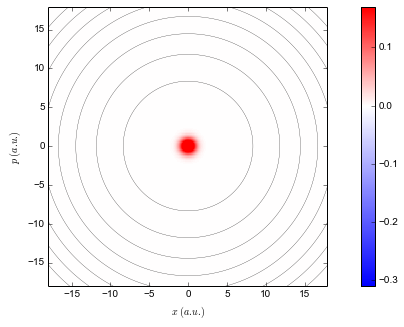

In [65]:
#------------------------------ Plot W_init --------------------------------------------------
PlotWigner(W_init)

 The renormalized state norm in x space is :   1.0
 The renormalized state norm in k space is : 1.0

Differences beetween W_x and probability in x space:
Max:  3.21964677141e-15
Min:  9.30016081819e-64

Differences beetween W_p and probability in k space:
Max:  2.75335310107e-14
Min:  3.26316612671e-20


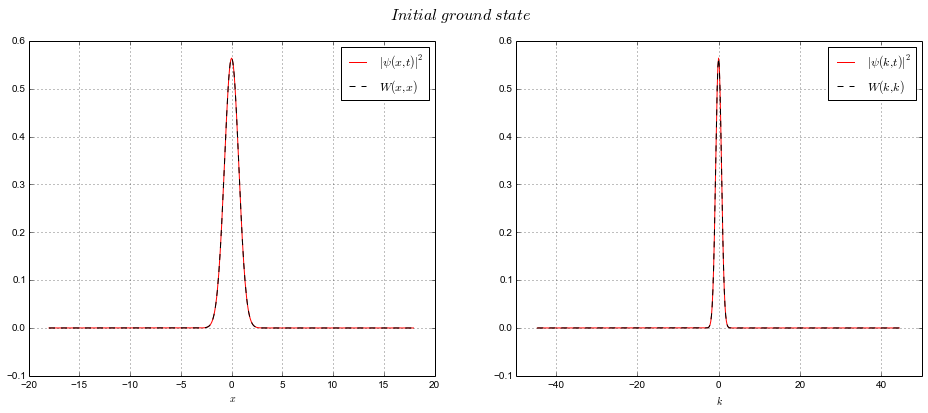

In [66]:
#------Comparing marginals : W_x ,W_p and probabilities : Phi_x and Phi_k for Ground state------

Plot_Marginals_prob(W_init  , Psi0_ground  ,"$Initial \\ ground \\ state$")


In [67]:
# --------------------Evolution of the theorical ground state-----------------------------------

with h5py.File('Psi_ground_end.hdf5', 'r') as f7:
     Psi_ground_end = f7['Psi_ground_end'].value
        
Psi_ground_end = Psi_ground_end.astype(np.complex128)


In [68]:
#-------------------Wigner transform of the propagate ground state----------------------------

W_end = W_Transform(Psi_ground_end)

max imaginary =  3.8354375683e-17
min real =  -5.12907510791e-15  max real =  0.318309886184
normalization =  1.0


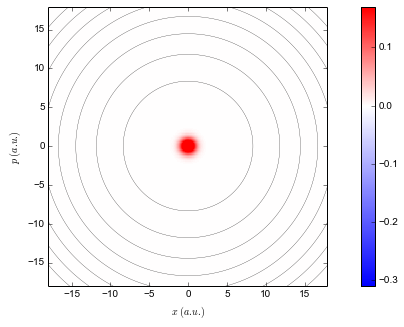

In [69]:
#------------------------------ Plot W_end --------------------------------------------------

PlotWigner(W_end)

 The renormalized state norm in x space is :   1.0
 The renormalized state norm in k space is : 1.0

Differences beetween W_x and probability in x space:
Max:  5.44009282066e-15
Min:  5.03591635617e-46

Differences beetween W_p and probability in k space:
Max:  2.6645352591e-14
Min:  4.1721558892e-20


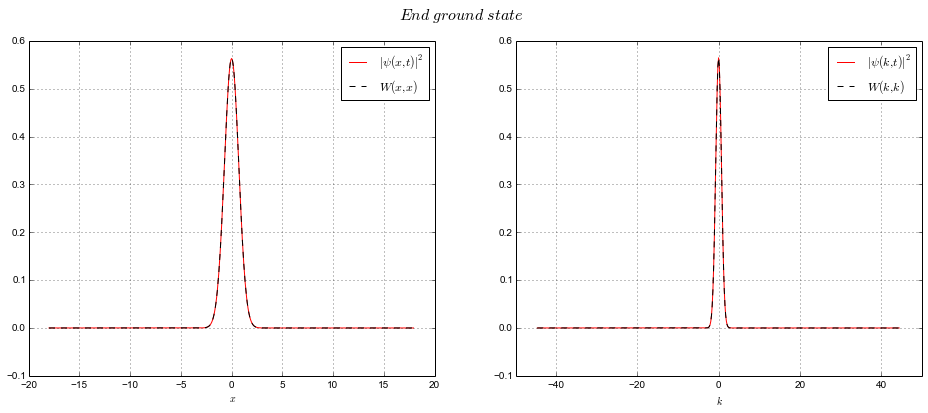

In [70]:
#------Comparing marginals : W_x ,W_p and probabilities : Phi_x and Phi_k for end Ground state------

Plot_Marginals_prob(W_end  , Psi_ground_end  ,"$End \\ ground \\ state$")

### 4.2 Superpositions of coherent states

In [71]:
# Initial superpositions of Coherents states

with h5py.File('Psi0_super_cohe.hdf5', 'r') as f8:
     Psi0_super_cohe = f8['Psi0_super_cohe'].value
        
Psi0_super_cohe = Psi0_super_cohe.astype(np.complex128)

In [72]:
#-------------------- Wigner transform of init superpositions of Coherents states  ---------------------------------

W_super_cohe_init = W_Transform(Psi0_super_cohe)

max imaginary =  7.93585652766e-17
min real =  -0.264735600778  max real =  0.318232183575
normalization =  1.0


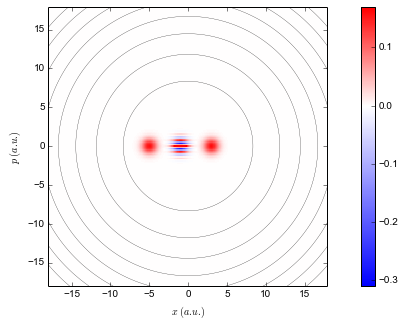

In [73]:
#------------------------------ Plot W_super_cohe_init --------------------------------------------------
PlotWigner(W_super_cohe_init)

 The renormalized state norm in x space is :   1.0
 The renormalized state norm in k space is : 1.0

Differences beetween W_x and probability in x space:
Max:  2.38697950294e-15
Min:  5.504320636e-33

Differences beetween W_p and probability in k space:
Max:  5.26245713672e-14
Min:  5.54642123816e-20


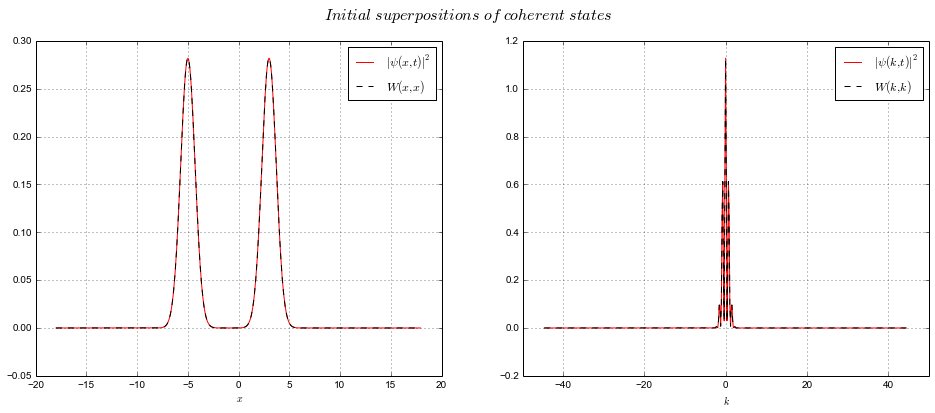

In [74]:
#Comparing  W_x ,W_p and probabilities : Phi_x and Phi_k for init superpositions of coherent states ------

Plot_Marginals_prob(W_super_cohe_init , Psi0_super_cohe  ,"$ Initial \\ superpositions \\ of \\ coherent \\ states$")

In [75]:
# superpositions of final Coherents states

with h5py.File('Psi_super_cohe_end.hdf5', 'r') as f9:
     Psi_super_cohe_end = f9['Psi_super_cohe_end'].value
        
Psi_super_cohe_end = Psi_super_cohe_end.astype(np.complex128)

In [76]:
#-------------------- Wigner transform of final superpositions of Coherents states  ---------------------------------

W_super_cohe_end = W_Transform(Psi_super_cohe_end)

max imaginary =  7.44492541949e-17
min real =  -0.271151356025  max real =  0.312473628123
normalization =  1.0


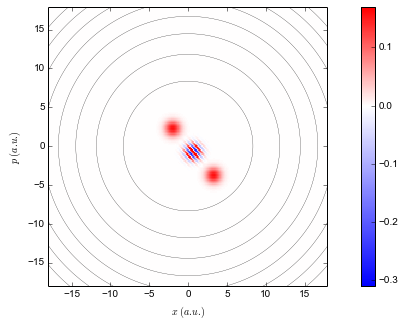

In [77]:
#------------------------------ Plot W_super_cohe_end --------------------------------------------------
PlotWigner(W_super_cohe_end)

In [78]:
# Negative area of final and initial cat states:

print "Neg. area of init cat state :" ,NegArea(W_super_cohe_init)
print "Neg. area of end  cat state :" ,NegArea(W_super_cohe_end )

Neg. area of init cat state : -0.316780911898
Neg. area of end  cat state : -0.315777090606


 The renormalized state norm in x space is :   1.0
 The renormalized state norm in k space is : 1.0

Differences beetween W_x and probability in x space:
Max:  2.16493489802e-15
Min:  0.0

Differences beetween W_p and probability in k space:
Max:  1.31561428418e-14
Min:  4.21413668223e-20


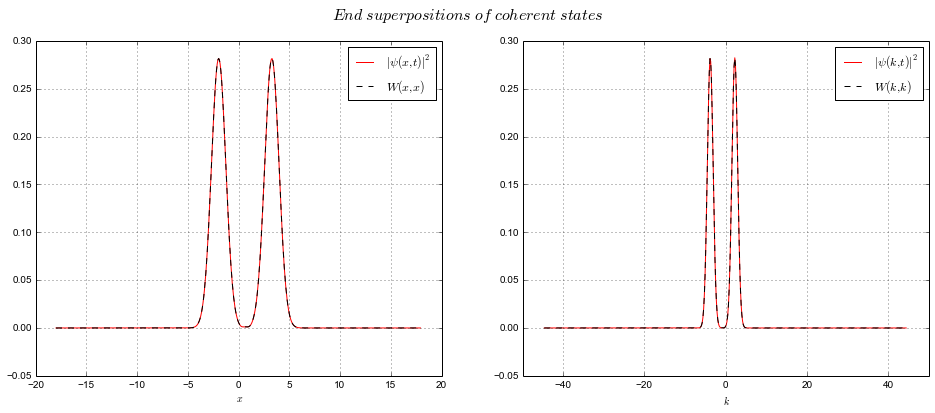

In [79]:
#Comparing  W_x ,W_p and probabilities : Phi_x and Phi_k for final superpositions of coherent states ------

Plot_Marginals_prob(W_super_cohe_end , Psi_super_cohe_end  ,"$ End \\ superpositions \\ of \\ coherent \\ states$")

### 4.3 Theorical ground state in phase space

In [80]:
W_theorical_ground = Wigner_HarmonicOscillator(0,mass,omega,0,0)
W_theorical_ground /= np.sum(W_theorical_ground)*dX*dK

max imaginary =  0.0
min real =  0.0  max real =  0.318309886184
normalization =  1.0


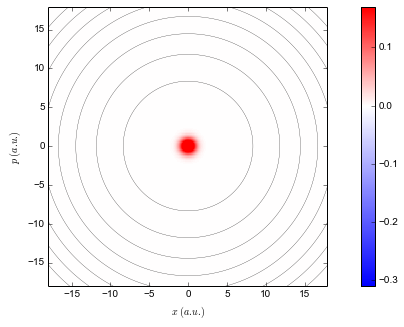

In [81]:
#------------------------------ Plot W_theorical_ground  ---------------------------------------
PlotWigner(W_theorical_ground )